# Walmart : predict weekly sales

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

%matplotlib inline

In [168]:
data = pd.read_csv("/Users/yagmuraslan/Desktop/JEDHA/Supervised ML/PROJECTS S ML/Walmart_Store_sales.csv")
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.00,18-02-2011,1572117.54,NaN,59.61,3.04,214.78,6.86
1,13.00,25-03-2011,1807545.43,0.00,42.38,3.44,128.62,7.47
2,17.00,27-07-2012,NaN,0.00,NaN,NaN,130.72,5.94
3,11.00,NaN,1244390.03,0.00,84.57,NaN,214.56,7.35
4,6.00,28-05-2010,1644470.66,0.00,78.89,2.76,212.41,7.09


# PART 1

## EDA

In [169]:
print("Number of Observations")
data.shape[0]

Number of Observations


150

In [170]:
#let's immediately drop all observations where the target variable missing
data.dropna(subset=['Weekly_Sales'], inplace =True)
len(data)

136

In [171]:
print("Percentage of missing values: % ")
display(100*data.isnull().sum()/data.shape[0])

Percentage of missing values: % 


Store           0.00
Date           13.24
Weekly_Sales    0.00
Holiday_Flag    8.09
Temperature    11.03
Fuel_Price      8.82
CPI             8.09
Unemployment   10.29
dtype: float64

I will principally use the date variable for the imputation of the missing values and the exploratory data analysis rather than regression itself. Since the target variable is weekly sales anyway, in other words aggregation of an entire week, I do not find the creation of a "day of the week" variable particularly necessary. Yet, month and year variables are going to be useful for the imputations.

In [172]:
df = data.copy() 
df['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

In [173]:
df = data.copy() 
df['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
df[['Day', 'Month', 'Year']] = df['Date'].dt.strftime('%d %m %Y').str.split(expand=True)
df[['Day', 'Month', 'Year']] = df[['Day', 'Month', 'Year']].astype('Int64', errors='ignore')

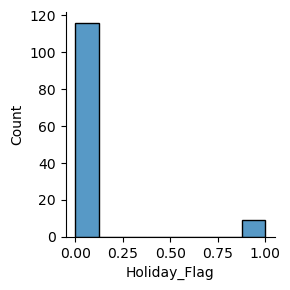

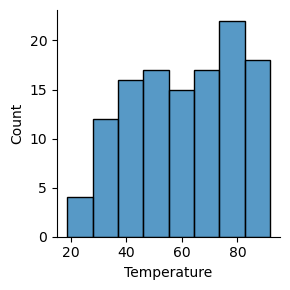

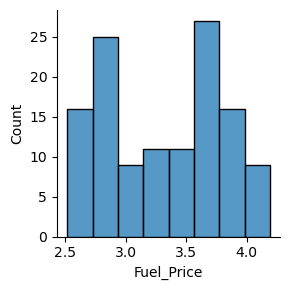

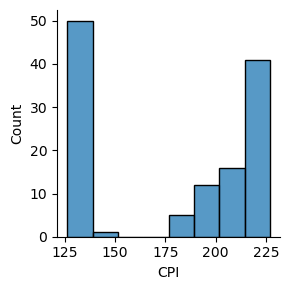

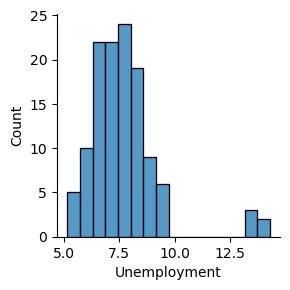

In [174]:
for column in df[['Holiday_Flag','Temperature','Fuel_Price','CPI','Unemployment']]:
    sns.displot(x=column, data=df, height = 3)
    plt.show()

In [175]:
df["Store"] = df["Store"].astype(int).astype(str)
df.groupby('Store')[['Date', 'Year', 'Temperature']].head()

,Date,Year,Temperature
0,2011-02-18,2011,59.61
1,2011-03-25,2011,42.38
3,NaT,<NA>,84.57
4,2010-05-28,2010,78.89
5,2010-05-28,2010,NaN
...,...,...,...
120,2010-09-17,2010,75.32
127,2010-07-09,2010,61.79
132,2011-07-22,2011,82.84
135,2010-09-10,2010,83.63


In [176]:
fig = px.line(df.sort_values(by='Date', ascending=True), x="Date", y="Weekly_Sales", color="Store", markers='Holiday_Flags')
fig.show()

In [177]:
fig = px.line(df.sort_values(by='Fuel_Price', ascending=True), x = "Fuel_Price", y = "Weekly_Sales", color = 'Store' )
fig.show()

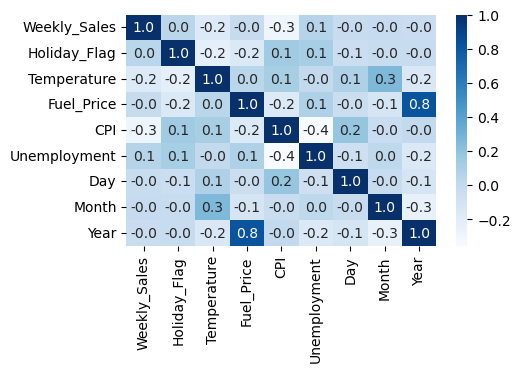

<Figure size 640x480 with 0 Axes>

In [178]:
correlation_matrix = df.corr()
plt.figure(figsize=(5,3))
sns.heatmap(correlation_matrix, cbar=True, fmt='.1f', annot=True, cmap='Blues')
plt.show()
plt.savefig('Correlation Heat map')


## Data Preprocessing 

- Categorical variables: Store, Holiday_Flag
- Numerical variables : Temperature, Fuel_Price, CPI, Unemployment, Year, Month, Day

Instead of using the SimpleImputer class from sklearn, I will designate custom imputers for each variable:
- for missing values of temperature, I will be using the average temperature of the corresponding month from other years
- for missing values of fuel_price, CPI and unemployment, I will be using the yearly averages
- for missing values of Holiday_Flag I will check the other observations from the same date, and if these ones possesses the Holiday_Flag information, I will retrieve it from there.

In [179]:
target = 'Weekly_Sales'
features_list = [item for item in df.columns if item not in target]

cat_features = ['Store', 'Holiday_Flag']
num_features = ['Temperature','Fuel_Price', 'CPI','Unemployment']

num_annual_means = ['Fuel_Price', 'CPI','Unemployment']
num_seasonal_means = ['Temperature']
cat_by_date = ['Holiday_Flag']

In [180]:
df_train, df_test = train_test_split(df, test_size = 0.25, random_state = 42)

In [182]:
class CustomImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        
        #if we're dealing with numeric data:
        for var in num_features :
            lower_bound = X[var].mean(skipna = True) - 3 * X[var].std(skipna = True)
            upper_bound = X[var].mean(skipna = True) + 3 * X[var].std(skipna = True)
            
            mask = (X[var].isna()) | ((X[var] > lower_bound) & (X[var] < upper_bound))
            X = X[mask].reset_index(drop=True)
            
        for var in num_annual_means:
            #dropping outliers by store, year before estimating annual means per store
            #imputing means
            X[var] = X[var].fillna(X.groupby(['Store', 'Year'])[var].transform('mean'))
            
        for var in num_seasonal_means: 
            #dropping outliers by store, month before estimating annual means per store
            #imputing means
            X[var] = X[var].fillna(X.groupby(['Store','Month'])[var].transform('mean'))
            

        #if we're dealing with categorical data 
        for var in cat_by_date: 
            X[var] = X[var].fillna(X.groupby('Date')[var].transform('mean')).astype(int, errors='ignore')
        
        #drop the values we couldn't impute
        X = X.dropna()

            #X = X[(X[var] > lower_bound) & (X[var] < upper_bound)]
        
        
        return X
    

In [183]:
imputer = Pipeline(
    steps=[
        ("custom_imputer", CustomImputer())
    ]
)

imputed_train = imputer.fit_transform(df_train)
imputed_test = imputer.transform(df_test)


In [184]:
num_transformer = Pipeline(steps =[
    #("custom_imputer", CustomNumericImputer()),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    #("custom_imputer", CustomCatImputer()),
    ('encoder', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        #('imp', imputer, features_list),
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)#actually Holiday_Flag is already one-hot encoded but it's ok
    ])

In [185]:
X_train, X_test, Y_train, Y_test = imputed_train[features_list], imputed_test[features_list], imputed_train[target], imputed_test[target]

In [186]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

#this one worked, however, in small datasets like this one, it's in my opinion better to do column transformations before
#train test split, because there is risk that the random split occurs in such a way that there may be categorical values
#in the test set that did not appear in the train set, and hence not one-hot encoded.
#in fact, this was the case for example when i used the random_seed 42 for train_test_split

# PART 2 : BASELINE MODEL

In [187]:
regressor = LinearRegression() 
regressor.fit(X_train, Y_train)

LinearRegression()

In [188]:
Y_train_pred = regressor.predict(X_train)
Y_test_pred = regressor.predict(X_test)

In [189]:
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

R2 score on training set :  0.962550092630623
R2 score on test set :  0.9672037632260497


In [190]:
column_names = []
for name, transformer, features in preprocessor.transformers_[:-1]: # loop over pipelines
    if name == 'num': 
        features = features 
    elif name == 'cat': # if pipeline is for categorical variables
        features = transformer.named_steps['encoder'].get_feature_names_out() # get output columns names from OneHotEncoder
    column_names.extend(features) # concatenate features names
        

In [191]:
coefs = pd.DataFrame(index = column_names, data = regressor.coef_.transpose(), columns=["coefficients"])
pd.options.display.float_format = '{:.2f}'.format
coefs

,coefficients
Temperature,-39208.21
Fuel_Price,-98637.89
CPI,580240.67
Unemployment,-19615.44
Store_10,1847179.05
Store_11,158432.81
Store_13,1775250.93
Store_14,976844.30
Store_15,446172.84
Store_16,-696610.46


Text(0.5, 1.0, 'Feature Importance')

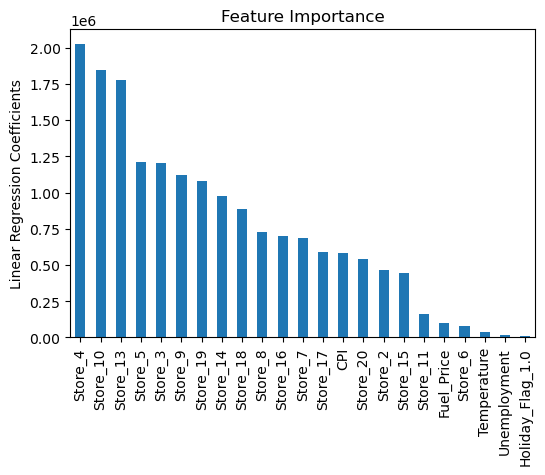

In [192]:
importance = pd.Series(np.abs(regressor.coef_.ravel()))
importance.index = column_names
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(6,4))
plt.ylabel('Linear Regression Coefficients')
plt.title('Feature Importance')

In [155]:
from sklearn.feature_selection import SelectFromModel
selector = SelectFromModel(estimator=LinearRegression()).fit(X_train, Y_train)
selector.get_support()

array([False, False, False, False,  True, False,  True,  True, False,
       False, False,  True,  True, False, False,  True,  True,  True,
       False, False, False,  True, False])

In [158]:
np.array(column_names)[selector.get_support()]

array(['Store_10', 'Store_13', 'Store_14', 'Store_18', 'Store_19',
       'Store_3', 'Store_4', 'Store_5', 'Store_9'], dtype='<U16')

# PART 3: REGULARIZATION

### Lasso Regularization

In [194]:
from sklearn.linear_model import Lasso

In [196]:
lasso = Lasso(max_iter = 8000, random_state=42)
lasso.fit(X_train, Y_train)

Y_train_pred = lasso.predict(X_train)
Y_test_pred = lasso.predict(X_test)

print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

R2 score on training set :  0.9625498135048639
R2 score on test set :  0.9671766980394116


Text(0.5, 1.0, 'Feature Importance')

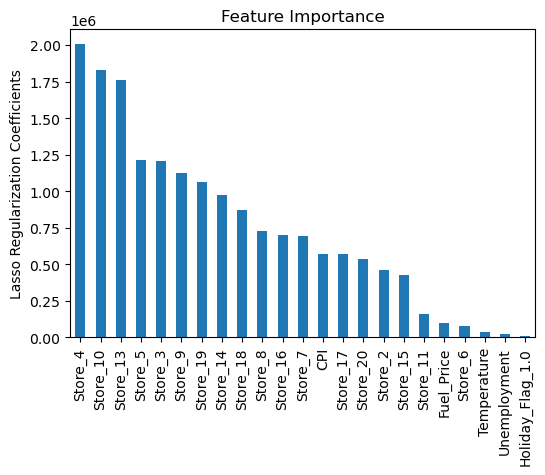

In [197]:
importance = pd.Series(np.abs(lasso.coef_.ravel()))
importance.index = column_names
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(6,4))
plt.ylabel('Lasso Regularization Coefficients')
plt.title('Feature Importance')

### Ridge Regularization

In [ ]:
from sklearn.linear_model import Ridge

In [200]:
ridge = Ridge(random_state = 42)
ridge.fit(X_train, Y_train)

Y_train_pred = ridge.predict(X_train)
Y_test_pred = ridge.predict(X_test)

print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

R2 score on training set :  0.9071716541939011
R2 score on test set :  0.8985547978280024


Text(0.5, 1.0, 'Feature Importance')

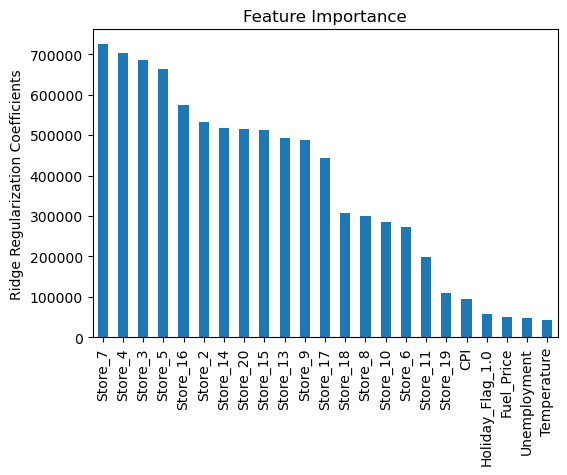

In [201]:
importance = pd.Series(np.abs(ridge.coef_.ravel()))
importance.index = column_names
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(6,4))
plt.ylabel('Ridge Regularization Coefficients')
plt.title('Feature Importance')

## Bonus : GridSearch

In [202]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Day,Month,Year
0,6,2011-02-18,1572117.54,NaN,59.61,3.04,214.78,6.86,18,2,2011
1,13,2011-03-25,1807545.43,0.00,42.38,3.44,128.62,7.47,25,3,2011
3,11,NaT,1244390.03,0.00,84.57,NaN,214.56,7.35,<NA>,<NA>,<NA>
4,6,2010-05-28,1644470.66,0.00,78.89,2.76,212.41,7.09,28,5,2010
5,4,2010-05-28,1857533.70,0.00,NaN,2.76,126.16,7.90,28,5,2010


In [209]:
def test(models, data , iterations = 100):
    results = {}
    for i in models:
        r2_train = []
        r2_test = []
        for j in range(iterations):
            data = imputer.fit_transform(data)
            ### here I performed imputation before split
            data_train, data_test = train_test_split(data, test_size = 0.25) 
           
            
            Xtrain, Xtest, Ytrain, Ytest = imputed_train[features_list],imputed_test[features_list], imputed_train[target], imputed_test[target]
            Xtrain = preprocessor.fit_transform(Xtrain)
            Xtest = preprocessor.transform(Xtest)
            
                                                               
            r2_test.append(r2_score(Ytest,
                                            models[i].fit(Xtrain, 
                                                         Ytrain).predict(Xtest)))
            r2_train.append(r2_score(Ytrain, 
                                             models[i].fit(Xtrain, 
                                                          Ytrain).predict(Xtrain)))
        results[i] = [np.mean(r2_train), np.mean(r2_test)]
    return pd.DataFrame(results)


In [212]:
lasso_params = {'alpha':[0.001, 0.01, 0.1, 1, 10]}
ridge_params = {'alpha':[0.001, 0.01, 0.1, 1, 10]}

models = {'OLS': LinearRegression(),
           'Lasso': GridSearchCV(Lasso(max_iter = 50000), #to ensure convergence
                               param_grid=lasso_params, cv = 10).fit(X_train, Y_train).best_estimator_,
           'Ridge': GridSearchCV(Ridge(), 
                               param_grid=ridge_params, cv = 10).fit(X_test, Y_test).best_estimator_}



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

/opt/anaconda3/lib/pyt

In [211]:
test(models, df)

,OLS,Lasso,Ridge
0,0.96,0.96,0.96
1,0.97,0.97,0.97
